# Parallelization of segments of the end to end ensemble training and evaluation for a text classification task

The problem taken from this [Kaggle competition](https://www.kaggle.com/c/spooky-author-identification).
Data can be downloaded from [here](https://www.kaggle.com/c/spooky-author-identification/data). The `train.csv` and `test.csv` must be present in the same directory as this notebook.
Also, download the Glove embeddings file `glove.840B.300d.zip` from [here](https://nlp.stanford.edu/projects/glove/), unzip it and keep in the same directory. One final thing you need to do is to split this file into 4 equal segments called `glove_part1.txt`, `glove_part2.txt`, `glove_part3.txt` and `glove_part4.txt`. We have done it using unix's `split` command

```
split -l 549005 glove.840B.300d.txt
```
and then renamed the parts like mentioned. These 4 split files also have to be in the same directory.
Once you have these, you can run this notebook in a pyhton 3 virtual environment where you have the following packages installed: `pandas, numpy, matplotlib, nltk, sklearn, keras, jupyter`
 

### Necessary imports

In [195]:
import pandas as pd
import numpy as np
import math
import nltk

from nltk.stem import WordNetLemmatizer 
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk import word_tokenize

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack as sp_hstack, vstack as sp_vstack
from scipy.interpolate import make_interp_spline, BSpline

from joblib import Parallel, delayed

import time

from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout, Layer, K
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping, Callback

import pickle
import matplotlib.pyplot as plt
%matplotlib inline

### Load the data

In [2]:
test_set = pd.read_csv('test.csv')
training_set = pd.read_csv('train.csv')

### Explore the data a bit

In [3]:
training_set.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [4]:
print(training_set[training_set.author == 'EAP'].shape)
print(training_set[training_set.author == 'HPL'].shape)
print(training_set[training_set.author == 'MWS'].shape)

(7900, 3)
(5635, 3)
(6044, 3)


### Train-validation split

In [5]:
df_train, df_val = train_test_split(training_set, stratify=training_set['author'], random_state=20, test_size=0.2, shuffle=True)

In [6]:
x_train = df_train['text']
y_train = df_train['author']
x_val = df_val['text']
y_val = df_val['author']

### Encode the label values in Keras ready format.

In [7]:
label_enc = LabelEncoder()
y_train = label_enc.fit_transform(y_train)
y_val = label_enc.transform(y_val)

### Utility method for getting succesive chunks of data. This is handy method for the data parallelization stuffs used later.

In [8]:
def next_chunk(data):
    for i in range(4):
        yield data[math.ceil(i * len(data) / 4):math.ceil((i + 1) * len(data) / 4)]

The following loss measure function has been taken from [this Kaggle kernel](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle). 

In [49]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

### Download some necessary nltk stuffs

In [54]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [55]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Utility methods for text preprocessing

In [56]:
ls = LancasterStemmer()
lem = WordNetLemmatizer()
stop_words = stopwords.words('english')

def normalize(text):
   words = word_tokenize(text) 
   words = [w for w in words if not w in stop_words]

   stemw = [ls.stem(w) for w in words]
   
   # 2- Lemmatization
   lemw = [lem.lemmatize(w) for w in stemw]
   return ' '.join(lemw)

def get_preprocessed_data(data):
    data = data.apply(normalize)
    return data

In [57]:
normalize(x_train[0])

'thi process , howev , afford mean ascertain dimend dungeon ; i might mak circuit , return point whent i set , without aw fact ; perfect uniform seem wal .'

### Sequential preprocessing

In [58]:
start_preprocess = time.time()
x_train_preprocessed = get_preprocessed_data(x_train)
end_preprocess = time.time()
time_preprocess_seq = end_preprocess - start_preprocess
print('Time taken by sequential pre_processing of training data: {} seconds'.format(time_preprocess_seq))

Time taken by sequential pre_processing of training data: 6.91552209854126 seconds


### Parallel preprocessing

In [60]:
start_preprocess = time.time()
x_train_preprocessed = np.hstack(Parallel(n_jobs=4, backend='loky', verbose=10)\
                            (delayed(get_preprocessed_data)(data) for data in next_chunk(x_train)))

end_preprocess = time.time()
time_preprocess_par = end_preprocess - start_preprocess
print('Time taken by parallellizing pre_processing of training data: {} seconds'.format(time_preprocess_par))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.9s remaining:    1.9s


Time taken by parallellizing pre_processing of training data: 2.296858787536621 seconds


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.2s finished


### Parallelization helped for pre-processing as seen sbove

In [61]:
x_val_preprocessed = get_preprocessed_data(x_val)

### TFIDF vectorizer

In [147]:
tfidf_vectorizer = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
tfidf_vectorizer.fit(x_train_preprocessed)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=1,
        stop_words='english', strip_accents='unicode', sublinear_tf=1,
        token_pattern='\\w{1,}', tokenizer=None, use_idf=1,
        vocabulary=None)

### Sequential TFIDF

In [148]:
start_tfidf = time.time()
x_train_prep_tfidf = tfidf_vectorizer.transform(x_train_preprocessed)
end_tfidf = time.time()
time_tfidf_seq = end_tfidf - start_tfidf
print('Time taken by sequential tfidf calculation of training data: {} seconds'.format(time_tfidf_seq))

Time taken by sequential tfidf calculation of training data: 0.39216184616088867 seconds


### Parallel TFIDF

In [150]:
start_tfidf = time.time()
x_train_prep_tfidf = sp_vstack(Parallel(n_jobs=4, backend='loky', verbose=10)\
                            (delayed(tfidf_vectorizer.transform)(data) for data in next_chunk(x_train_preprocessed)))

end_tfidf = time.time()
time_tfidf_par = end_tfidf - start_tfidf
print('Time taken by parallel tfidf calculation of training data: {} seconds'.format(time_tfidf_par))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.5s remaining:    2.5s


Time taken by parallel tfidf calculation of training data: 4.662719249725342 seconds


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    4.6s finished


### Parallelization did not help for the tfidf calculation.

In [151]:
x_val_prep_tfidf = tfidf_vectorizer.transform(x_val_preprocessed)

### Shallow models

### Logistic Regression

In [63]:
logreg_model = LogisticRegression(C=11.0)
logreg_model.fit(x_train_prep_tfidf, y_train)

d:\envs\deep_learning\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\envs\deep_learning\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=11.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [64]:
logreg_model.score(x_val_prep_tfidf, y_val)

0.7913687436159347

## Naive Bayes

In [65]:
nb_model = MultinomialNB()
nb_model.fit(x_train_prep_tfidf, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [66]:
nb_model.score(x_val_prep_tfidf, y_val)

0.7911133810010215

## Random Forest

In [67]:
rfmodel = RandomForestClassifier(n_estimators=100, random_state=1, min_samples_leaf=3, n_jobs=1)

In [68]:
rfmodel.fit(x_train_prep_tfidf, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [69]:
rfmodel.score(x_val_prep_tfidf, y_val)

0.7017364657814096

### Train the 3 models (Logistic Regression, Naive Bayes and Random Forest) sequentially

In [87]:
models = [logreg_model, rfmodel, nb_model]

def fit_and_evaluate_model(model, x_train, y_train, x_val, y_val):
    model.fit(x_train, y_train)
    probs = model.predict_proba(x_val)
    score = model.score(x_val, y_val)
    return probs, score

start_ensemble = time.time()
results = []
for model in models:
    results.append(fit_and_evaluate_model(model, x_train_prep_tfidf, y_train, x_val_prep_tfidf, y_val))
end_ensemble = time.time()
time_ensemble_seq = end_ensemble - start_ensemble
print('Time taken by sequential run of ensemble model: {} seconds'.format(time_ensemble_seq))

d:\envs\deep_learning\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\envs\deep_learning\lib\site-packages\sklearn\linear_model\logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Time taken by sequential run of ensemble model: 4.455329418182373 seconds


## Now Parallellize the same training

In [77]:
start_ensemble = time.time()
results = Parallel(n_jobs=3, backend='loky', verbose=0)\
                            (delayed(fit_and_evaluate_model)(model, x_train_prep_tfidf, y_train, x_val_prep_tfidf, y_val) \
                             for model in models)
end_ensemble = time.time()
time_ensemble_par = end_ensemble - start_ensemble
print('Time taken by parallel run of ensemble model: {} seconds'.format(time_ensemble_par))

Time taken by parallel run of ensemble model: 3.4047114849090576 seconds


### Parallelization helped for the ensemble model run.

## Deep Neural models

### Sequential reading of the embeddings file

In [91]:
# The code for utility function read_embeddings is taken from:
# https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.1-using-word-embeddings.ipynb
def read_embeddings(file):
    embeddings_index = {}
    with open(file, encoding="utf8") as f:
       for line in f:
           values = line.split(' ')
           word = values[0]
           coefs = np.asarray(values[1:], dtype='float32')
           embeddings_index[word] = coefs
    return embeddings_index

start_embedding = time.time()
read_embeddings('glove.840B.300d.txt')
end_embedding = time.time()
time_embedding_seq = end_embedding - start_embedding
print('Time taken by sequential embeddings read: {} seconds'.format(time_embedding_seq))

Time taken by sequential embeddings read: 153.56502962112427 seconds


### The embeddings file is huge in size - almost 5.5 GB. So we have splitted the file into 4 parts so that it can be read in parallel by 4 worker process working on 4 processor cores. 
### Parallel reading of the embeddings file

In [94]:
start_embedding = time.time()
files = ['glove_part1.txt', 'glove_part2.txt', 'glove_part3.txt', 'glove_part4.txt']
indices = Parallel(n_jobs=4, backend='loky', verbose=10)\
                            (delayed(read_embeddings)(file) for file in files)
embeddings_index = {}
for index in indices:
    embeddings_index.update(index)
end_embedding = time.time()

#time_embedding_par = end_embedding - start_embedding
print('Time taken by parallel embeddings read: {} seconds'.format(time_embedding_par))
print('Found %s word vectors.' % len(embeddings_index))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  2.2min remaining:  2.2min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.3min finished


Time taken by parallel embeddings read: 111.45695376396179 seconds
Found 2196016 word vectors.


### Parallelization helped for reading embeddings file

### Tokenization with keras

In [98]:
max_len = 100
#max_words = 10000
# using keras tokenizer here
tokenizer = text.Tokenizer(num_words=None)
tokenizer.fit_on_texts(x_train_preprocessed)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 11776 unique tokens.


### Build embedding matrix

In [99]:
# The code for embedding_matrix is taken from:
# https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.1-using-word-embeddings.ipynb
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
   embedding_vector = embeddings_index.get(word)
   if embedding_vector is not None:
       embedding_matrix[i] = embedding_vector

### Utility method for sequencing senteces

In [100]:
def get_sequence_data(data):
   data = tokenizer.texts_to_sequences(data)
   # zero pad the sequences
   data = sequence.pad_sequences(data, maxlen=max_len)
   return data

### Sequential execution of sentence sequencing

In [101]:
start_sequence = time.time()
x_train_sequence = get_sequence_data(x_train_preprocessed)
end_sequence = time.time()
time_sequence_seq = end_sequence - start_sequence
print('Time taken by sequential tokenization and sequencing: {} seconds'.format(end - start))

Time taken by sequential tokenization and sequencing: 33.29940700531006 seconds


### Parallel execution of sentence sequencing

In [102]:
start_sequence = time.time()
x_train_sequence = np.vstack(Parallel(n_jobs=4, backend='loky', verbose=10)\
                            (delayed(get_sequence_data)(data) for data in next_chunk(x_train_preprocessed)))
end_sequence = time.time()
time_sequence_par = end_sequence - start_sequence
print('Time taken by parallel tokenization and sequencing: {} seconds'.format(end - start))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Time taken by parallel tokenization and sequencing: 24.17801570892334 seconds


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   24.0s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   24.0s remaining:   24.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   24.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   24.1s finished


### Parallelization helped for tokenizing and sequencing.

In [106]:
x_val_sequence = get_sequence_data(x_val_preprocessed)

In [108]:
y_train_enc = np_utils.to_categorical(y_train)
y_val_enc = np_utils.to_categorical(y_val)

### Definition of neural models (RNN with LSTM)

In [132]:
def nn_model(dropout=0.3):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                        300,
                        weights=[embedding_matrix],
                        input_length=max_len,
                        trainable=False))
    model.add(SpatialDropout1D(0.3))
    model.add(LSTM(100, dropout=dropout, recurrent_dropout=dropout))

    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(dropout))

    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(dropout))

    model.add(Dense(3))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def fit_and_evaluate_nn_model(model, x_train, y_train, x_val, y_val, batch_size=512):
    model.fit(x_train, y=y_train, batch_size=batch_size, epochs=10, verbose=1)
    probs = model.predict(x_val)
    _, score = model.evaluate(x_val, y_val)
    return probs, score

def get_nn_models():
    return [nn_model(0.3), nn_model(0.4), nn_model(0.5)]

### Sequential execution of the training of 3 different neural models (with 3 different dropout rates)

In [134]:
start_ensemble_nn = time.time()
nn_results = []
models_seq = get_nn_models()
for model in models_seq:
    nn_results.append(fit_and_evaluate_nn_model(model, x_train_sequence, y_train_enc, x_val_sequence, y_val_enc))
end_ensemble_nn = time.time()
time_ensemble_nn_seq = end_ensemble_nn - start_ensemble_nn
print('Time taken by sequential training of 3 models: {} seconds'.format(time_ensemble_nn_seq))

Epoch 1/10
15663/15663 [==============================] - 57s 4ms/step - loss: 1.0283 - acc: 0.4702
Epoch 2/10
15663/15663 [==============================] - 60s 4ms/step - loss: 0.9346 - acc: 0.5542
Epoch 3/10
15663/15663 [==============================] - 62s 4ms/step - loss: 0.8983 - acc: 0.5849
Epoch 4/10
15663/15663 [==============================] - 65s 4ms/step - loss: 0.8811 - acc: 0.5974
Epoch 5/10
15663/15663 [==============================] - 63s 4ms/step - loss: 0.8642 - acc: 0.6006
Epoch 6/10
15663/15663 [==============================] - 61s 4ms/step - loss: 0.8478 - acc: 0.6156
Epoch 7/10
15663/15663 [==============================] - 61s 4ms/step - loss: 0.8182 - acc: 0.6296
Epoch 8/10
15663/15663 [==============================] - 62s 4ms/step - loss: 0.8076 - acc: 0.6342
Epoch 9/10
15663/15663 [==============================] - 63s 4ms/step - loss: 0.7814 - acc: 0.6553
Epoch 10/10
3916/3916 [==============================] - 7s 2ms/step
Epoch 1/10
15663/15663 [=======

### Parallel execution of the training of same 3 models above

In [135]:
start_ensemble_nn = time.time()
models_par = get_nn_models()
nn_results = Parallel(n_jobs=3, backend='loky', verbose=1)\
                            (delayed(fit_and_evaluate_nn_model)(model, x_train_sequence, y_train_enc, 
                                                                x_val_sequence, y_val_enc) \
                             for model in models_par)
end_ensemble_nn = time.time()
time_ensemble_nn_par = end_ensemble_nn - start_ensemble_nn
print('Time taken by parallellizing training of 3 models: {} seconds'.format(time_ensemble_nn_par))

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Time taken by parallellizing training of 3 models: 809.9761328697205 seconds


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 13.8min finished


### Parallelization helped for neural model ensembling

In [124]:
time_ensemble_nn_seq

2127.9264843463898

In [125]:
time_ensemble_nn_par

809.9761328697205

## Generate Results for test data

### Preprocess the test data

In [129]:
x_test = test_set['text']
x_test_preprocessed = get_preprocessed_data(x_test)
x_test_prep_tfidf = tfidf_vectorizer.transform(x_test_preprocessed)
x_test_sequence = get_sequence_data(x_test_preprocessed)

### Sequential execution of probability prediction of the 6 models we got so far (3 shallow and 3 deep neural)

In [143]:
start_ensemble_result = time.time()
ensemble_probs = models[0].predict_proba(x_test_prep_tfidf)
for model in models[1:]:
    ensemble_probs += model.predict_proba(x_test_prep_tfidf)
for model in models_par:
    ensemble_probs += model.predict(x_test_sequence)
ensemble_probs /= 6
end_ensemble_result = time.time()
time_ensemble_result_seq = end_ensemble_result - start_ensemble_result
print('Time taken by sequential ensemble result calculation: {} seconds'.format(time_ensemble_result_seq))

Time taken by sequential ensemble result calculation: 35.67901802062988 seconds


### Parallel execution of probability prediction of the 6 models we got so far (3 shallow and 3 deep neural). We let the shallow models still predict sequentiall since they are pretty fast and parallelization doesn't help too much. However we run the deep models' predicition in parallel.

In [156]:
start_ensemble_result = time.time()

ensemble_probs = models[0].predict_proba(x_test_prep_tfidf)
for model in models[1:]:
    ensemble_probs += model.predict_proba(x_test_prep_tfidf)
    
ensemble_results_deep = Parallel(n_jobs=3, backend='loky', verbose=1)\
                            (delayed(model.predict)(x_test_sequence) \
                             for model in models_par)
for result in ensemble_results_deep:
    ensemble_probs +=result
ensemble_probs /= 6

end_ensemble_result = time.time()
time_ensemble_result_par = end_ensemble_result - start_ensemble_result
print('Time taken by parallel ensemble result calculation: {} seconds'.format(time_ensemble_result_par))

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Time taken by parallel ensemble result calculation: 14.850965023040771 seconds


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   14.3s finished


### Parallelization of the neural models helped improving performance

### Our most significant performance gain came with parallelizing the deep model training step. We will try to visualize it more deeply using traing data of different sizes.

In [163]:
sizes = [3000, 6000, 9000, 12000]

In [164]:
times_nn_seq = []
for i, size in enumerate(sizes):
    start_ensemble_nn = time.time()
    models_seqq = get_nn_models()
    for model in models_seqq:
        fit_and_evaluate_nn_model(model, x_train_sequence[:size], y_train_enc[:size], x_val_sequence, y_val_enc)
    end_ensemble_nn = time.time()
    times_nn_seq.append(end_ensemble_nn - start_ensemble_nn)
    print('Time taken by sequential training of 3 models with size {}: {} seconds'.format(size, times_nn_seq[i]))

Epoch 1/10
3000/3000 [==============================] - 13s 4ms/step - loss: 1.0813 - acc: 0.4173
Epoch 2/10
3000/3000 [==============================] - 11s 4ms/step - loss: 1.0515 - acc: 0.4663
Epoch 3/10
3000/3000 [==============================] - 12s 4ms/step - loss: 1.0135 - acc: 0.4800
Epoch 4/10
3000/3000 [==============================] - 12s 4ms/step - loss: 0.9778 - acc: 0.5213
Epoch 5/10
3000/3000 [==============================] - 12s 4ms/step - loss: 0.9563 - acc: 0.5337
Epoch 6/10
3000/3000 [==============================] - 12s 4ms/step - loss: 0.9219 - acc: 0.5593
Epoch 7/10
3000/3000 [==============================] - 13s 4ms/step - loss: 0.9195 - acc: 0.5603
Epoch 8/10
3000/3000 [==============================] - 12s 4ms/step - loss: 0.8873 - acc: 0.5787
Epoch 9/10
3000/3000 [==============================] - 13s 4ms/step - loss: 0.8642 - acc: 0.6010
Epoch 10/10
3916/3916 [==============================] - 10s 2ms/step
Epoch 1/10
3000/3000 [==========================

In [166]:
times_nn_parr = []
for i, size in enumerate(sizes):
    start_ensemble_nn = time.time()
    models_parr = get_nn_models()
    Parallel(n_jobs=3, backend='loky', verbose=1)\
                            (delayed(fit_and_evaluate_nn_model)(model, x_train_sequence[:size], y_train_enc[:size], 
                                                                x_val_sequence, y_val_enc) \
                             for model in models_parr)
    end_ensemble_nn = time.time()
    times_nn_parr.append(end_ensemble_nn - start_ensemble_nn)
    print('Time taken by parallel training of 3 models with size {}: {} seconds'.format(size, times_nn_parr[i]))

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  2.8min finished


Time taken by parallel training of 3 models with size 3000: 178.8060863018036 seconds


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  5.4min finished


Time taken by parallel training of 3 models with size 6000: 335.29078340530396 seconds


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  7.9min finished


Time taken by parallel training of 3 models with size 9000: 487.3409073352814 seconds


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Time taken by parallel training of 3 models with size 12000: 640.6674711704254 seconds


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 10.4min finished


In [178]:
times_nn_seq.append(time_ensemble_nn_seq)
times_nn_parr.append(time_ensemble_nn_par)
sizes.append(len(x_train))

In [206]:
def interplotate_smooth(x, y):
    x_new = np.linspace(min(x) - 100, max(x) + 100, 300)

    spl = make_interp_spline(x, y, k=3)
    y_new = spl(x_new)
    return x_new, y_new

### Plot the execution time trend against data size for the deep models training step

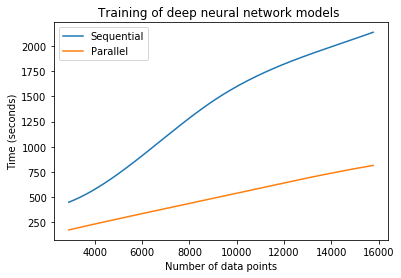

In [232]:
plt.plot(*interplotate_smooth(sizes, times_nn_seq), label='Sequential')
plt.plot(*interplotate_smooth(sizes, times_nn_parr), label='Parallel')
plt.xlabel('Number of data points')
plt.ylabel('Time (seconds)')
plt.title('Training of deep neural network models ')
plt.legend()
plt.savefig('neural_seq_vs_par.png')
plt.show()

### We will also try to experiment and visualize the second most performance gaining step of our implementation, which is the preprocessing.

In [218]:
times_prep_seq = []
for i, size in enumerate(sizes[:4]):
    start_preprocess = time.time()
    temp = get_preprocessed_data(x_train[:size])
    end_preprocess = time.time()
    times_prep_seq.append(end_preprocess - start_preprocess)
    print('Time taken by sequential preprocessing with size {}: {} seconds'.format(size, times_prep_seq[i]))

Time taken by sequential preprocessing with size 3000: 1.348273515701294 seconds
Time taken by sequential preprocessing with size 6000: 2.667013168334961 seconds
Time taken by sequential preprocessing with size 9000: 4.019038200378418 seconds
Time taken by sequential preprocessing with size 12000: 5.396446943283081 seconds


In [219]:
times_prep_seq.append(time_preprocess_seq)

In [224]:
times_prep_parr = []
for i, size in enumerate(sizes[:5]):
    start_preprocess = time.time()
    temp = np.hstack(Parallel(n_jobs=4, backend='loky', verbose=10)\
                            (delayed(get_preprocessed_data)(data) for data in next_chunk(x_train)))
    end_preprocess = time.time()
    times_prep_parr.append(end_preprocess - start_preprocess)
    print('Time taken by parallel preprocessing with size {}: {} seconds'.format(size, times_prep_parr[i]))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.1s remaining:    2.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Time taken by parallel preprocessing with size 3000: 2.2475900650024414 seconds


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.1s remaining:    2.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Time taken by parallel preprocessing with size 6000: 2.2816946506500244 seconds


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.0s remaining:    2.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Time taken by parallel preprocessing with size 9000: 2.1778769493103027 seconds


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.2s remaining:    2.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Time taken by parallel preprocessing with size 12000: 2.408221960067749 seconds


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.3s remaining:    2.3s


Time taken by parallel preprocessing with size 15663: 2.5456459522247314 seconds


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.4s finished


### Plot the execution time trend against data size for the preprocessing step

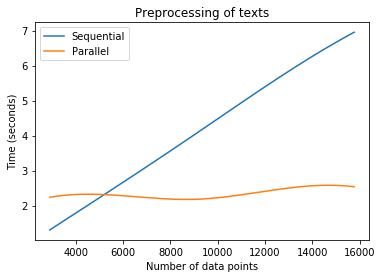

In [230]:
plt.plot(*interplotate_smooth(sizes, times_prep_seq), label='Sequential')
plt.plot(*interplotate_smooth(sizes, times_prep_parr), label='Parallel')
plt.xlabel('Number of data points')
plt.ylabel('Time (seconds)')
plt.title('Preprocessing of texts')
plt.legend()
plt.savefig('prep_seq_vs_par.png')
plt.show()